In [0]:
!pip install vaderSentiment

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

First, lets just have a look at given data:

In [0]:
import pandas as pd
df = pd.read_json("/content/drive/My Drive/test_task/reviews.json", lines=True)
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,NaN,NaN
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,NaN,NaN
2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,NaN,NaN
3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,NaN,NaN
4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,NaN,NaN


Some overall info:

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
overall           1000000 non-null int64
verified          1000000 non-null bool
reviewTime        1000000 non-null object
reviewerID        1000000 non-null object
asin              1000000 non-null object
style             358331 non-null object
reviewerName      999917 non-null object
reviewText        999636 non-null object
summary           999862 non-null object
unixReviewTime    1000000 non-null int64
vote              121947 non-null object
image             16345 non-null object
dtypes: bool(1), int64(2), object(9)
memory usage: 84.9+ MB


Let's consider at column 'summary'. I think that this is a customer's review in short. 

In [0]:
df.summary.value_counts().iloc[:10]

Five Stars       246158
Four Stars        41040
Three Stars       13583
One Star           7035
Two Stars          4950
Great product      3069
Great              2680
Perfect            2290
Good product       2128
Works great        2039
Name: summary, dtype: int64

Hmm, the first five values look like default values for this field. Let's take a closer look: I suppose, that correlation between target and summary field will be hight in rows with these values.

In [0]:
five = df[df['summary']=='Five Stars']['overall'].value_counts()
four = df[df['summary']=='Four Stars']['overall'].value_counts()
three = df[df['summary']=='Three Stars']['overall'].value_counts()
two = df[df['summary']=='Two Stars']['overall'].value_counts()
one = df[df['summary']=='One Star']['overall'].value_counts()

frame = {'Five Stars': five, 'Four Stars': four,'Three Stars': three, 'Two Star': two, 'One Star': one}
pd.DataFrame(frame)

,Five Stars,Four Stars,Three Stars,Two Star,One Star
1,67,14,15,23,7003
2,37,5,13,4912,2
3,32,11,13520,8,5
4,32,40964,19,4,5
5,245990,46,16,3,20


As I expected :)

We even can avoid ML approaches to these rows... So, will see.

Let's have a look at columns: vote, verified, image, style too.

Probably reviews with the high vote will be positive. I suppose that verified can also be correlated with the target. Style - don't know what exactly means, but let's try. The same point with the image field.

In [0]:
df.vote.value_counts().iloc[:10]

2     45953
3     23375
4     13601
5      8583
6      5997
7      4107
8      3168
9      2408
10     1897
11     1528
Name: vote, dtype: int64

In [0]:
df.verified.value_counts()

True     947137
False     52863
Name: verified, dtype: int64

In [0]:
df['style'].astype(str).nunique()

11703

I will pick these features to separate dataframe to visualize the correlation

In [0]:
image = df.image.isna()
style = df['style'].astype(str)
verified = df.verified.astype(int)
vote = df.vote.iloc[:].str.replace(',', '.').astype(float).fillna(0)
target = df.overall

frame = {'image': image, 'style': style, 'vote': vote, 'verified': verified, 'target': target}
corr = pd.DataFrame(frame)

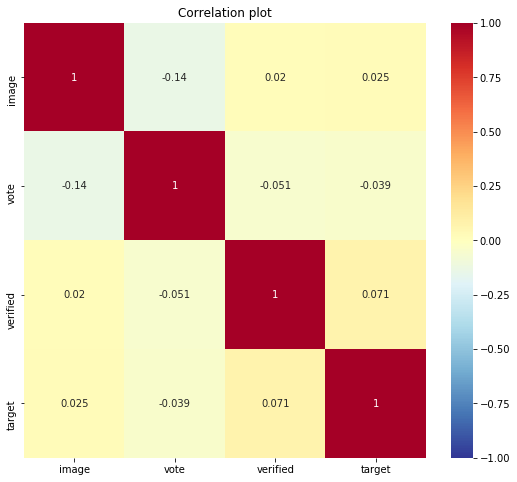

In [0]:
plt.figure(figsize = (9, 8))

sns.heatmap(corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -1.0, annot = True, vmax = 1.0)
plt.title('Correlation plot')
plt.show()

Ops, my assumptions were wrong. Maybe these features are useless in our case.

Also, I would like to try Vader. Using this tool you can extract how much text is positive, negative and so on. I think that it have a sense.

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import StratifiedShuffleSplit

analyzer = SentimentIntensityAnalyzer()

Let's make subsample as it can take much time to calculate metrics for all million rows. We will use StratifiedShuffleSplit to get a good representative subsample.

In [0]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
_, sample_index = next(sss.split(df['summary'], target))

sub_sample = df.iloc[sample_index]

In [0]:
target = pd.DataFrame(target.iloc[sample_index])

for column in ['reviewText', 'summary']:

    sent_list = []
    for sentiment in sub_sample[column].astype(str):
        sentiments = analyzer.polarity_scores(sentiment)
        list_temp=[]
        for key, value in sentiments.items():
            temp = value
            list_temp.append(temp)
        sent_list.append(list_temp)

    temp_df = pd.DataFrame(sent_list, columns=['compound','neg','neu','pos'], index=sub_sample.index)
    target = pd.merge(target, temp_df, left_index=True,right_index=True)

And the same visualization:

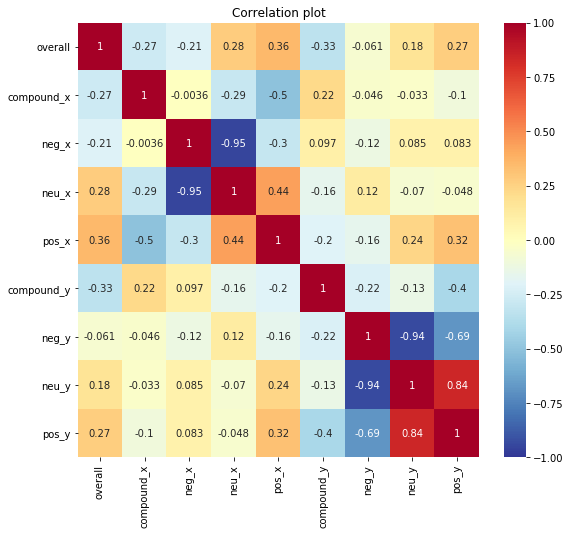

In [0]:
plt.figure(figsize = (9, 8))

sns.heatmap(target.corr(), cmap = plt.cm.RdYlBu_r, vmin = -1.0, annot = True, vmax = 1.0)
plt.title('Correlation plot');

Hmm, I wouldn't say that even 0.36 is a good reason to waste time on building the model on these features. Yes, probably there is a non-linear correlation, but as I expected linear I will not stop at this step.